# CHILD ML Analysis
    - ML Pipeline for CHILD Dataset from the very beginning

##### Step One: Feature Selection Strategies (Insights)

##### Step Two: Making ML Pipelines

##### Step Three: Tunning & Feature Engineering/Selection (data review) to Improve Performance (Insights)

##### Step Four: Visualization of model performance

##### Step Five: Paper, Deployment

### Libraries

In [1]:
# Preferences of autoformatting & Multiple Output
%load_ext nb_black

from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

import warnings

warnings.filterwarnings("ignore")

import researchpy as rp  # For auto-statistics/EDA of dataframe
from tqdm.notebook import tqdm  # For process display
import importlib  # For viewing library structure (dependancies, etc)

import sys

sys.path.append("../src")

from data import *
from utils import *
from conf import *

import utils as UT
import data as DT


import random

import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

<IPython.core.display.Javascript object>

### Data

In [2]:
# df_raw = generate_raw_xlsx()
df_child = load_child_with_more()

Loading ('../data/addon/Prenatal Q91PRNMH18WK.xlsx', '../output/CHILD_raw.xlsx', '../data/addon/breastfeeding data.xlsx', '../data/addon/Prenatal Q91PRNMH18WK.xlsx'), and merging
The dataframe merged with more information is saved to ../output/ with name of CHILD_with_addon.xlsx


<IPython.core.display.Javascript object>

In [3]:
df_targeted = target_selector(df_child, target_mapping={2: np.nan})

The dimension of original dataframe for process is (3455, 157)
Number of categorical features is:  56
Number of numeric features is:  24
Number of target variables is:  13
Number of dropped features is:  63
The difference of features of targeted and original dataframe is :{'Subject_Number'}
The number of missing value for target label is: 809
------------------------------------------------------
Note: Target variable can be one of: 
 ['Asthma_Diagnosis_3yCLA', 'Asthma_Diagnosis_5yCLA', 'Recurrent_Wheeze_1y', 'Recurrent_Wheeze_3y', 'Recurrent_Wheeze_5y', 'Wheeze_Traj_Type', 'Medicine_for_Wheeze_5yCLA', 'Viral_Asthma_3yCLA', 'Triggered_Asthma_3yCLA', 'Viral_Asthma_5yCLA', 'Triggered_Asthma_5yCLA', 'Cumulative_Wheeze_36m', 'Cumulative_Wheeze_60m']
------------------------------------------------------
****Target variable will be renamed to y for easy access.**** 



<IPython.core.display.Javascript object>

In [4]:
df_shrunk, X, y, df_dropped = sample_selector(df_targeted)

A total of 15 / 165 (9.1%) for asthma positive are dropped due to more than 10 missing value in the sample.

The total number of dropped samples is 181


<IPython.core.display.Javascript object>

In [5]:
# Restore raw data
df = df_shrunk.copy()
X = df_shrunk.drop(columns="y").copy()
y = df_shrunk["y"].copy()

<IPython.core.display.Javascript object>

###  Test Run of Transformers

In [6]:
df_for_ml = generate_trainable_dataset(X, y, add_indicator_threshold=100)

The output columns will be: RIfrequency_earlier_report, RIseverity_earlier_report, RIfrequency_later_report, RIseverity_later_report
---------------------------------------------------------------------------------------------------
Given the correlation threshhold of 0.9, the columns that will be removed are:['Dad_Inhalant', 'Noncold_Wheeze_3m', 'Antibiotics_Usage', 'Mom_Inhalant']. Please see the following correlation:{'Antibiotics_Usage <> Number_of_AntibioticsCourse': 0.9415315843229445, 'Noncold_Wheeze_3m <> Epi_Noncold_Wheeze_3m': 0.9269937706805971, 'Dad_Inhalant <> Dad_Atopy': 1.0, 'Mom_Inhalant <> Mom_Atopy': 0.9981287992337443}
---------------------------------------------------------------------------------------------------
Given the correlation threshhold of 0.7, the columns that will be considered to be dropped are:['First_10min_Measure', 'CSED_12m', 'Dad_Inhalant', 'Noncold_Wheeze_3m', 'RIseverity_later_report', 'Parental_Asthma', 'Mother_Condition_Delivery', 'CSED_6m', 

<IPython.core.display.Javascript object>

In [7]:
# Backup df_for_ml
df_for_ml_backup = df_for_ml.copy()

<IPython.core.display.Javascript object>

In [8]:
df_for_ml.y.value_counts(normalize=True)
df_for_ml.y.value_counts(normalize=False)
# Restore X,y for ML modelling
X = df_for_ml.drop(columns="y")
y = df_for_ml.y
X.shape
y.shape

0.0    0.932372
1.0    0.067628
Name: y, dtype: float64

0.0    2068
1.0     150
Name: y, dtype: int64

(2218, 99)

(2218,)

<IPython.core.display.Javascript object>

In [9]:
# Scaled ML using MinMaxScaler()
df_ml_scaled = pd.DataFrame(
    MinMaxScaler().fit_transform(df_for_ml), columns=df_for_ml.columns
)

for i in df_ml_scaled.columns:
    df_ml_scaled[i] = df_ml_scaled[i].astype("float16")

X = df_ml_scaled.drop(columns="y")
y = df_ml_scaled.y
X.shape
y.shape

(2218, 99)

(2218,)

<IPython.core.display.Javascript object>

## Now begins the INTERESTING ML Journey!

In [10]:
def view_module_functions(module_alias):
    """
    Quick review of self-written functions and classes
    """
    return [
        i
        for i in dir(module_alias)
        if (not i.isupper()) & ~(i.startswith("_")) & (len(i) > 6)
    ]


print(view_module_functions(UT))
print(view_module_functions(DT))

['ApgarTransformer', 'BaseEstimator', 'BirthTransformer', 'CatNaNImputer', 'ColumnFilter', 'DiscretizePSS', 'ImputerStrategizer', 'KNNImputer', 'Log1pTransformer', 'MissForest', 'RespiratoryTransformer', 'SimpleImputer', 'TransformerMixin', 'generate_trainable_dataset', 'load_child_with_more', 'numeric_imputation', 'numeric_imputation_selector', 'sample_selector', 'sklearn', 'target_selector']
['data_mapping', 'data_repo_review', 'data_selection', 'dummy_reversed_features', 'feature_selection', 'generate_raw_xlsx']


<IPython.core.display.Javascript object>

In [11]:
# Summary of created dataframe for CHILD
def df_summary(X):
    """
    Overview the number of unique values, Top percentage of value distribution, for each feature 
    """

    cols_to_inspect = X.columns

    top_percentage = {}
    for i in X[cols_to_inspect].columns:
        top_percentage[i] = round(
            (X[i].value_counts(normalize=True).values[0] * 100), 2
        )
    per_ser = pd.Series(top_percentage)

    df_overview = (
        pd.concat(
            [
                X[cols_to_inspect].nunique(),
                X[cols_to_inspect].mean(),
                per_ser,
                X[cols_to_inspect].max(),
                X[cols_to_inspect].sum(),
                X[cols_to_inspect].var(),
            ],
            axis=1,
        )
        .rename(
            columns={
                0: "Num_Unique_Values",
                1: "Mean_Value",
                2: "Top_Percentage",
                3: "Max_Value",
                4: "Number_of_Binary_Positive",
                5: "Variance",
            }
        )
        .sort_values(by="Top_Percentage", ascending=False)
    )

    return df_overview


X_summary = df_summary(X)
X_summary.sort_values(by="Variance")

,Num_Unique_Values,Mean_Value,Top_Percentage,Max_Value,Number_of_Binary_Positive,Variance
Prenatal_Hypotension,2,0.001803,99.82,1.0,4.000000,0.001801
Apgar_Score_5min,8,0.938477,88.86,1.0,2082.000000,0.001957
Prenatal_Cardiac_Disorder,2,0.004059,99.59,1.0,9.000000,0.004044
Epi_Noncold_Wheeze_3m,17,0.013840,95.45,1.0,30.703125,0.005623
RIseverity_earlier_report,14,0.063660,36.70,1.0,141.250000,0.006081
...,...,...,...,...,...,...
PSS_12m_Low_Stress,2,0.544434,54.46,1.0,1208.000000,0.248047
PSS_18week_Low_Stress,2,0.532227,53.25,1.0,1181.000000,0.249023
Gender_M,2,0.531250,53.11,1.0,1178.000000,0.249268
BF_12m,2,0.475098,52.48,1.0,1054.000000,0.249390


<IPython.core.display.Javascript object>

In [12]:
def view_y_proportions(df, columns_of_interest, thresh=0):
    """
    Gadget to view the asthma proportions for different columns during feature selection
    """
    general_proportion = round((100 * df[df.y == 1].shape[0] / df.shape[0]), 2)
    print(
        "The proportion of definite asthma outcome for general cohorts is {}%".format(
            general_proportion
        )
    )
    asthma_for_col_number = []
    asthma_for_col_proportion = []
    col_with_thresh_number = []
    for i in columns_of_interest:

        total_of_subsamples = df[df[i] > thresh].shape[0]

        if 1 in df[df[i] > thresh].y.value_counts().sort_values(ascending=True).index:
            number_of_asthma = (
                df[df[i] > thresh].y.value_counts().sort_values(ascending=True).loc[1]
            )
        else:
            number_of_asthma = 0

        proportion = round(
            (number_of_asthma / (total_of_subsamples + 0.000001) * 100), 2
        )

        col_with_thresh_number.append(total_of_subsamples)
        asthma_for_col_proportion.append(proportion)
        asthma_for_col_number.append(number_of_asthma)
    #         print(
    #             "The proportion of asthma outcome when the value of {} is greater than {} is {}% or {} out of {}".format(
    #                 i, thresh, proportion, number_of_asthma, total_of_subsamples
    #             )
    #         )

    col_y_df = pd.DataFrame(
        [
            asthma_for_col_proportion,
            asthma_for_col_number,
            col_with_thresh_number,
            np.ones(len(col_with_thresh_number)) * thresh,
        ],
        index=[
            "Asthma_Proportion_over_thresh",
            "Asthma_Outcome_over_thresh",
            "Total_Number_over_thresh",
            "Thresh",
        ],
        columns=columns_of_interest,
    )

    general_ser = pd.Series(
        [general_proportion, df[df.y == 1].shape[0], df.shape[0], 0],
        name="*****GENERAL*****",
        index=[
            "Asthma_Proportion_over_thresh",
            "Asthma_Outcome_over_thresh",
            "Total_Number_over_thresh",
            "Thresh",
        ],
    )

    return col_y_df.T.append(general_ser).sort_values(
        by="Asthma_Proportion_over_thresh", ascending=False
    )


view_y_proportions(df_ml_scaled, df_ml_scaled.columns[:-1], 0.4)[
    view_y_proportions(df_ml_scaled, df_ml_scaled.columns[:-1], 0.4)[
        "Asthma_Proportion_over_thresh"
    ]
    < 7.0
]

The proportion of definite asthma outcome for general cohorts is 6.76%
The proportion of definite asthma outcome for general cohorts is 6.76%


,Asthma_Proportion_over_thresh,Asthma_Outcome_over_thresh,Total_Number_over_thresh,Thresh
Prenatal_Bleeding,6.96,11.0,158.0,0.4
F10min_Suction,6.96,35.0,503.0,0.4
BF_1m,6.84,142.0,2077.0,0.4
Jaundice_Birth_Missing,6.82,9.0,132.0,0.4
Apgar_Score_1min,6.80,150.0,2206.0,0.4
Apgar_Score_5min,6.77,150.0,2216.0,0.4
Weight_3m,6.77,91.0,1344.0,0.4
*****GENERAL*****,6.76,150.0,2218.0,0.0
BF_9m,6.73,95.0,1411.0,0.4
F10min_No_Measure_Needed,6.72,93.0,1384.0,0.4


<IPython.core.display.Javascript object>

### ML Libraries

In [30]:
# Preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder

# Feature selection
from sklearn.feature_selection import (
    SelectPercentile,
    SelectKBest,
    SelectFwe,
    chi2,
    mutual_info_classif,
    SelectFromModel,
    f_classif,
    SequentialFeatureSelector,
    RFECV,
)
from sklearn.inspection import permutation_importance

# Imbalance Learn
from imblearn.over_sampling import RandomOverSampler

# Models
from sklearn.linear_model import LogisticRegression, Lasso, LassoLarsCV
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# Ensemble
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Model Metrics, Parameters, Evaluation
from sklearn.model_selection import (
    StratifiedKFold,
    GridSearchCV,
    cross_val_score,
    train_test_split,
)


from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    roc_curve,
    classification_report,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
)

# Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion


# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

<IPython.core.display.Javascript object>

### Feature Selection   <a id='0'></a> 

1. [Lasso](#lasso)
2. [Chi2](#chi2)
3. [f_value](#f_classif)
4. [FalsePositiveRate](#fpr)
5. [p_value](#fwe)
6. [mutual_information](#mutal)
7. [Recursive Feature Elimination](#RFE)
8. [SelectFromModel](#selm)
9. [permutation_importance](#permutation)
10. [SequentialFeatureSelector](#sequentialgreed)

### Feature Engineering
1. [PCA](#pca)
2. [FeatureAgglomeration](#clusteragglomeration)
3. [Derived_New_Features_with_Expertise_and_Logic](#derivenewfeature)

#### (1) Lasso - Observation - 1

In [14]:
# plt.style.available
# plt.style.use("seaborn-bright")

<IPython.core.display.Javascript object>

In [15]:
# Automatic Alphas with StratifiedKfold
skf = StratifiedKFold(n_splits=2, shuffle=True, random_state=1015)
model = LassoLarsCV(cv=skf).fit(X, y)

<IPython.core.display.Javascript object>

(0.00015, 0.00085)

Text(0, 0.5, 'Lasso Regression CV')

Text(0.5, 0, 'Regularization Factor - Alphas')

Text(0.5, 1.0, 'Regression Coefficient Progression for Lasso Path')

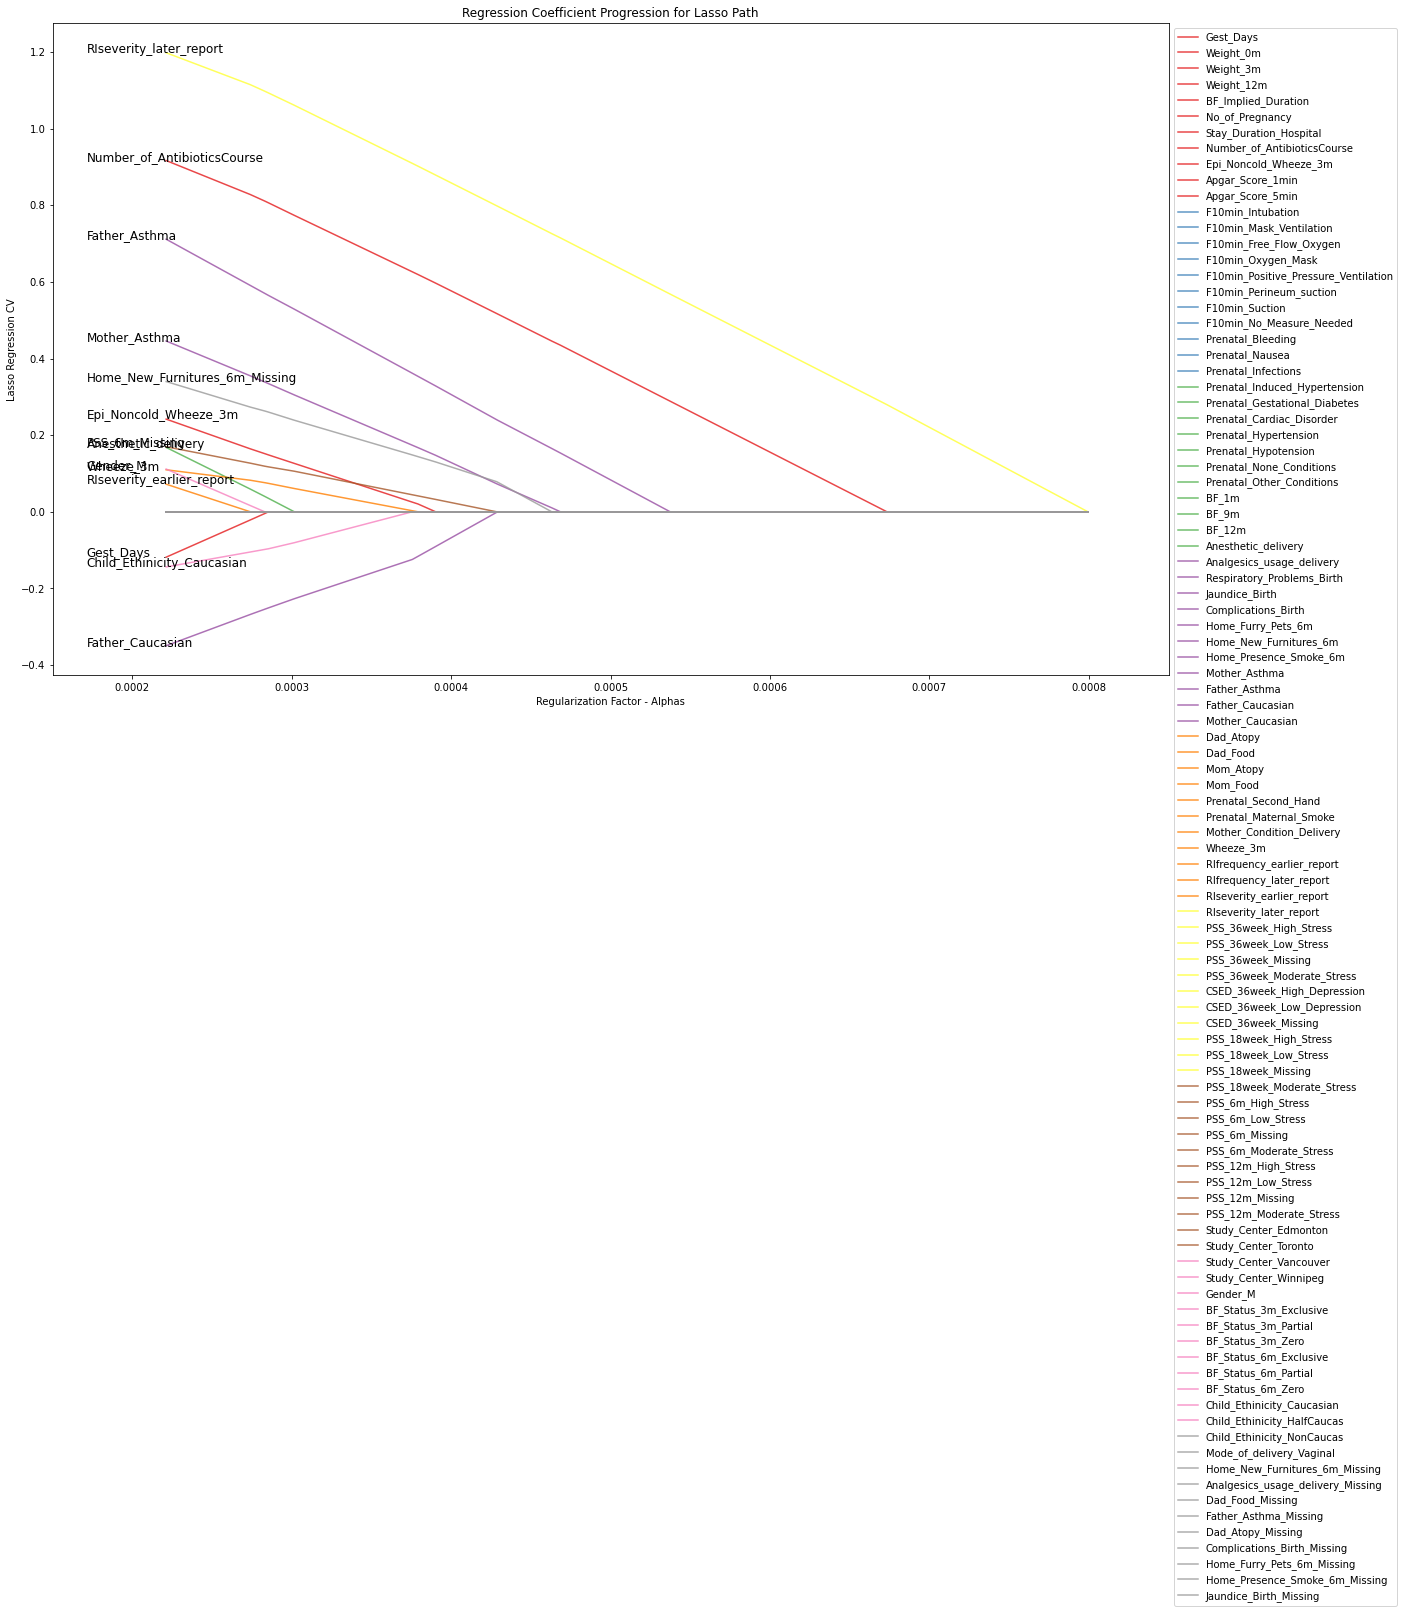

<IPython.core.display.Javascript object>

In [17]:
fig, ax = plt.subplots(figsize=(20, 12))
columns_of_total = X.shape[1]
start = 0
end = X.shape[1]
number_of_display = end - start

cm = iter(plt.get_cmap("Set1")(np.linspace(0, 1, number_of_display)))
for i in range(start, end):
    c = next(cm)
    _ = ax.plot(
        model.alphas_, model.coef_path_.T[:, i], c=c, alpha=0.8, label=X.columns[i]
    )


lassocv_df = pd.DataFrame(
    data=model.coef_path_.T, columns=X.columns, index=model.alphas_
)

y_pos_ser = lassocv_df.iloc[-1:].T.iloc[:, 0][lassocv_df.iloc[-1:].T.iloc[:, 0] != 0]
x_pos = float(lassocv_df.iloc[-1:].T.columns.values)
x_pos_list = [x_pos for i in range(len(y_pos_ser))]

for x_t, y_t, text in zip(x_pos_list, y_pos_ser.values, y_pos_ser.index):
    axtxt = ax.text(
        x_t - 0.00005,
        y_t,
        text,  # Used to format it K representation
        color="black",
        rotation="horizontal",
        size="large",
    )

ax.legend(X.columns[start:end], bbox_to_anchor=(1, 1))

plt.xlim([0.00015, 0.00085])
plt.ylabel("Lasso Regression CV")
plt.xlabel("Regularization Factor - Alphas")
plt.title("Regression Coefficient Progression for Lasso Path")

fig.savefig("../images/lasso_progression",dpi=300,bbox_inches='tight')


In [18]:
view_y_proportions(
    df_for_ml, lassocv_df.sum()[lassocv_df.sum() != 0].sort_values().index, 0.5
)

The proportion of definite asthma outcome for general cohorts is 6.76%


,Asthma_Proportion_over_thresh,Asthma_Outcome_over_thresh,Total_Number_over_thresh,Thresh
RIseverity_later_report,30.00,24.0,80.0,0.5
Epi_Noncold_Wheeze_3m,16.42,11.0,67.0,0.5
RIseverity_earlier_report,14.29,6.0,42.0,0.5
Wheeze_3m,14.20,23.0,162.0,0.5
Home_New_Furnitures_6m_Missing,12.76,31.0,243.0,0.5
PSS_6m_Missing,12.65,32.0,253.0,0.5
Number_of_AntibioticsCourse,12.63,48.0,380.0,0.5
Father_Asthma,12.61,44.0,349.0,0.5
Mother_Asthma,11.40,52.0,456.0,0.5
Gender_M,8.23,97.0,1178.0,0.5


<IPython.core.display.Javascript object>

#### Lasso - Observation - 2 - All features decreasing pattern   <a id='lasso'></a>

[return](#0)

In [19]:
coef_dict = {}
for alp in tqdm(np.arange(0.000001, 0.0009, 0.000005)):
    lasso_model = Lasso(alpha=alp).fit(X, y)
    coef_dict[alp] = list(lasso_model.coef_)

res = pd.DataFrame(data=coef_dict.values(), columns=X.columns, index=coef_dict.keys()).T

  0%|          | 0/180 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

In [20]:
# For those with bitter coefficient (impact)
res[0.000001][abs(res[0.000001]) > 0.05].sort_values().index
view_y_proportions

Index(['Mother_Condition_Delivery', 'RIfrequency_later_report', 'Gest_Days',
       'F10min_Oxygen_Mask', 'Prenatal_Hypotension', 'PSS_36week_Missing',
       'Prenatal_Other_Conditions', 'Home_New_Furnitures_6m_Missing',
       'Father_Asthma', 'BF_Status_6m_Zero', 'BF_Status_6m_Exclusive',
       'BF_Status_6m_Partial', 'Prenatal_Gestational_Diabetes',
       'Prenatal_Cardiac_Disorder', 'Epi_Noncold_Wheeze_3m',
       'Apgar_Score_5min', 'Number_of_AntibioticsCourse',
       'RIseverity_later_report'],
      dtype='object')

<function __main__.view_y_proportions(df, columns_of_interest, thresh=0)>

<IPython.core.display.Javascript object>

<AxesSubplot:>

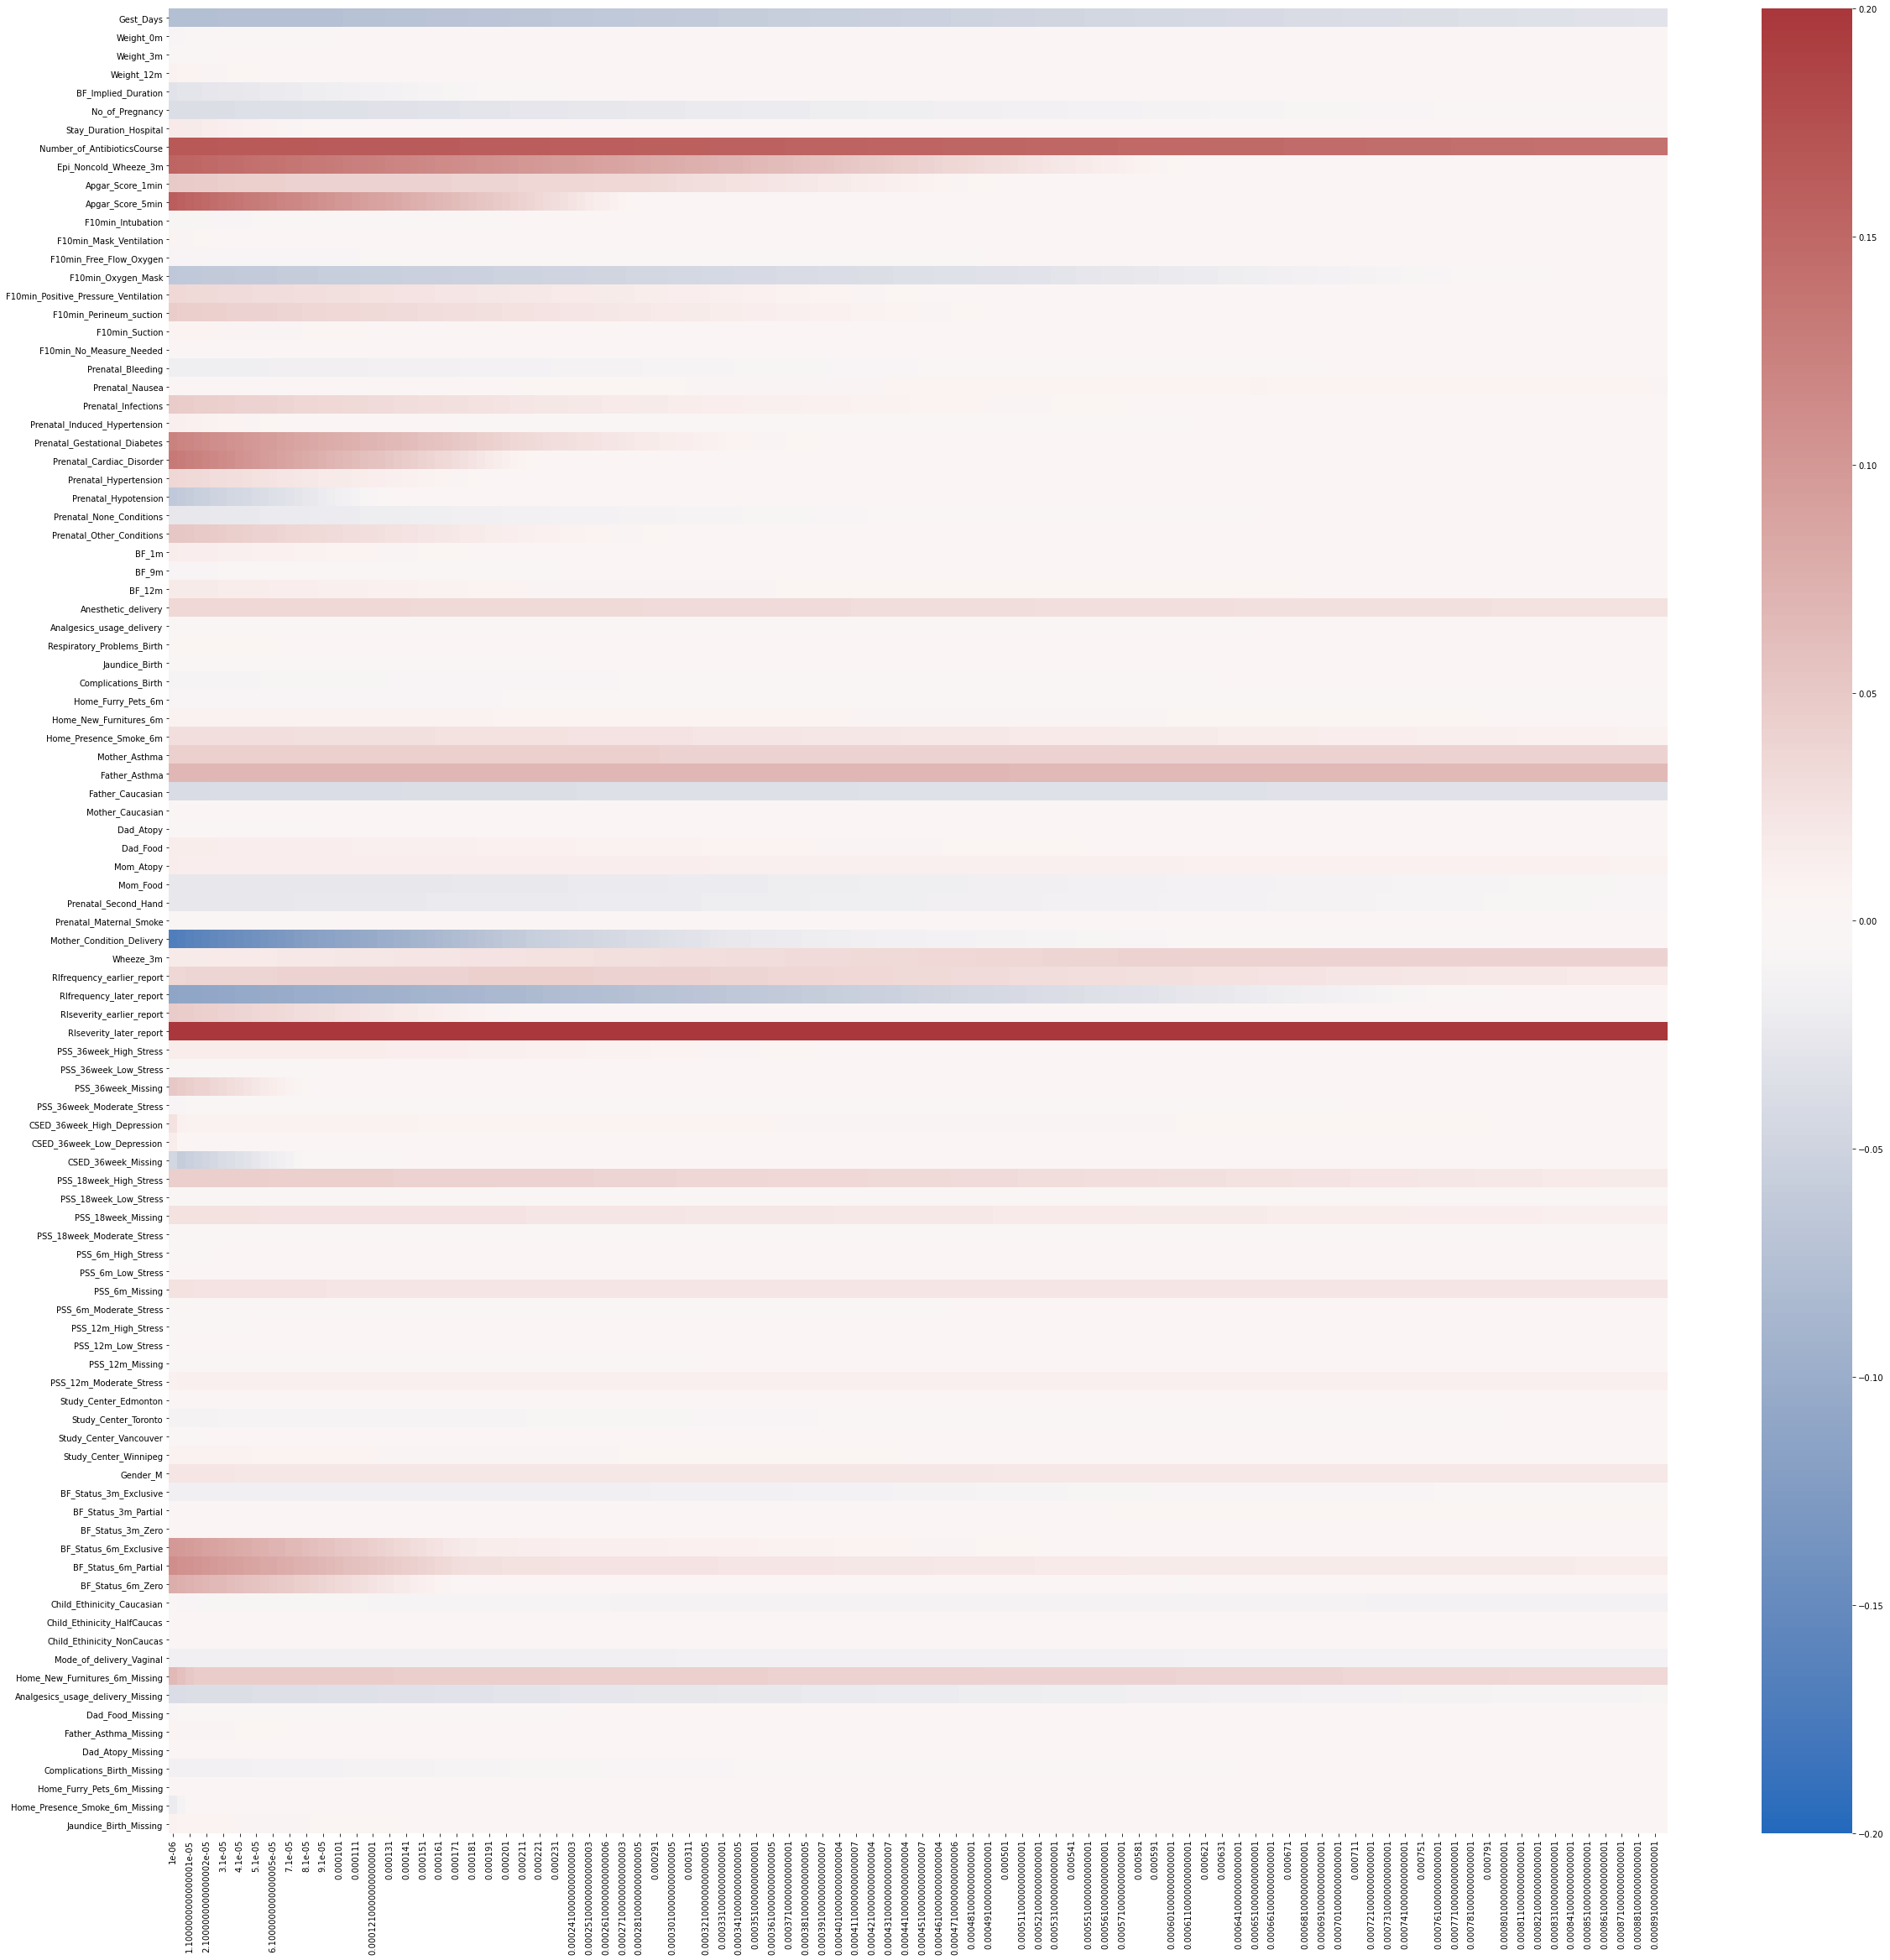

<IPython.core.display.Javascript object>

In [22]:
# sns.color_palette("YlOrBr", as_cmap=True)
fig, ax = plt.subplots(figsize=(40, 40))
sns.heatmap(res.iloc[:, :], vmax=0.2, vmin=-0.2, cmap="vlag", ax=ax)

#### (2) Chi2 & SelectPercentile  <a id='chi2'></a>

[return](#0)

In [23]:
clf = Pipeline([("chi2", SelectPercentile(chi2)), ("rfc", RandomForestClassifier())])

skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=1020)

<IPython.core.display.Javascript object>

  0%|          | 0/11 [00:00<?, ?it/s]

Pipeline(steps=[('chi2',
                 SelectPercentile(percentile=1,
                                  score_func=<function chi2 at 0x7f883015c0d0>)),
                ('rfc', RandomForestClassifier())])

Pipeline(steps=[('chi2',
                 SelectPercentile(percentile=5,
                                  score_func=<function chi2 at 0x7f883015c0d0>)),
                ('rfc', RandomForestClassifier())])

Pipeline(steps=[('chi2',
                 SelectPercentile(score_func=<function chi2 at 0x7f883015c0d0>)),
                ('rfc', RandomForestClassifier())])

Pipeline(steps=[('chi2',
                 SelectPercentile(percentile=15,
                                  score_func=<function chi2 at 0x7f883015c0d0>)),
                ('rfc', RandomForestClassifier())])

Pipeline(steps=[('chi2',
                 SelectPercentile(percentile=20,
                                  score_func=<function chi2 at 0x7f883015c0d0>)),
                ('rfc', RandomForestClassifier())])

Pipeline(steps=[('chi2',
                 SelectPercentile(percentile=30,
                                  score_func=<function chi2 at 0x7f883015c0d0>)),
                ('rfc', RandomForestClassifier())])

Pipeline(steps=[('chi2',
                 SelectPercentile(percentile=40,
                                  score_func=<function chi2 at 0x7f883015c0d0>)),
                ('rfc', RandomForestClassifier())])

Pipeline(steps=[('chi2',
                 SelectPercentile(percentile=60,
                                  score_func=<function chi2 at 0x7f883015c0d0>)),
                ('rfc', RandomForestClassifier())])

Pipeline(steps=[('chi2',
                 SelectPercentile(percentile=80,
                                  score_func=<function chi2 at 0x7f883015c0d0>)),
                ('rfc', RandomForestClassifier())])

Pipeline(steps=[('chi2',
                 SelectPercentile(percentile=90,
                                  score_func=<function chi2 at 0x7f883015c0d0>)),
                ('rfc', RandomForestClassifier())])

Pipeline(steps=[('chi2',
                 SelectPercentile(percentile=100,
                                  score_func=<function chi2 at 0x7f883015c0d0>)),
                ('rfc', RandomForestClassifier())])

<Figure size 864x576 with 0 Axes>

<ErrorbarContainer object of 3 artists>

Text(0.5, 1.0, 'Performance of the RandomForest-Chi2 varying the percentile of features selected')

([<matplotlib.axis.XTick at 0x7f8881d10970>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

Text(0.5, 0, 'Percentile')

Text(0, 0.5, 'Precision Score')

(0.25, 104.75, -0.09688967887004965, 1.022161214914588)

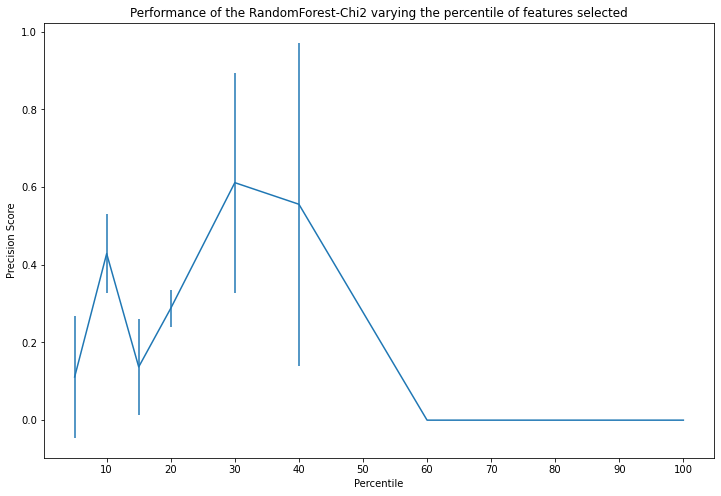

<IPython.core.display.Javascript object>

In [24]:
# #############################################################################
# Plot the cross-validation score as a function of percentile of features
score_means = list()
score_stds = list()
percentiles = (1, 5, 10, 15, 20, 30, 40, 60, 80, 90, 100)

for percentile in tqdm(percentiles):
    clf.set_params(chi2__percentile=percentile)
    this_scores = cross_val_score(clf, X, y, cv=skf, scoring="precision")
    score_means.append(this_scores.mean())
    score_stds.append(this_scores.std())


plt.figure(figsize=(12, 8))
plt.errorbar(percentiles, score_means, np.array(score_stds))
plt.title(
    "Performance of the RandomForest-Chi2 varying the percentile of features selected"
)
plt.xticks(np.linspace(0, 100, 11, endpoint=True))
plt.xlabel("Percentile")
plt.ylabel("Precision Score")
plt.axis("tight")
plt.show()

In [25]:
chi_perc = SelectPercentile(chi2, percentile=30)
chi_perc.fit_transform(X, y)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float16)

<IPython.core.display.Javascript object>

In [28]:
# X.columns[chi_perc.get_support()]
chi_perc.get_feature_names_out()
len(chi_perc.get_feature_names_out())

chi2_res = pd.DataFrame(
    [list(chi_perc.pvalues_), list(chi_perc.scores_)],
    index=["P_value", "Scores"],
    columns=X.columns,
).T

chi2_res[chi2_res.P_value < 0.05]

array(['Number_of_AntibioticsCourse', 'Epi_Noncold_Wheeze_3m',
       'F10min_Oxygen_Mask', 'Home_Furry_Pets_6m', 'Mother_Asthma',
       'Father_Asthma', 'Father_Caucasian', 'Mother_Caucasian',
       'Dad_Food', 'Wheeze_3m', 'RIfrequency_earlier_report',
       'RIfrequency_later_report', 'RIseverity_later_report',
       'PSS_36week_High_Stress', 'CSED_36week_High_Depression',
       'PSS_18week_High_Stress', 'PSS_18week_Low_Stress',
       'PSS_6m_Low_Stress', 'PSS_6m_Missing', 'PSS_12m_Low_Stress',
       'PSS_12m_Moderate_Stress', 'Gender_M', 'BF_Status_3m_Partial',
       'Child_Ethinicity_Caucasian', 'Child_Ethinicity_HalfCaucas',
       'Child_Ethinicity_NonCaucas', 'Home_New_Furnitures_6m_Missing',
       'Analgesics_usage_delivery_Missing', 'Home_Furry_Pets_6m_Missing',
       'Home_Presence_Smoke_6m_Missing'], dtype=object)

30

,P_value,Scores
Number_of_AntibioticsCourse,0.000227,13.593395
Epi_Noncold_Wheeze_3m,0.020537,5.365660
Mother_Asthma,0.000079,15.574192
Father_Asthma,0.000014,18.906728
Wheeze_3m,0.000219,13.662723
RIseverity_later_report,0.015953,5.808098
PSS_18week_High_Stress,0.041555,4.153235
PSS_6m_Missing,0.000193,13.897915
Gender_M,0.044303,4.044969
BF_Status_3m_Partial,0.044243,4.047259


<IPython.core.display.Javascript object>

In [29]:
view_y_proportions(df_ml_scaled, chi2_res[chi2_res.P_value < 0.05].index, 0)

The proportion of definite asthma outcome for general cohorts is 6.76%


,Asthma_Proportion_over_thresh,Asthma_Outcome_over_thresh,Total_Number_over_thresh,Thresh
PSS_18week_High_Stress,14.00,7.0,50.0,0.0
Epi_Noncold_Wheeze_3m,13.86,14.0,101.0,0.0
Wheeze_3m,13.53,23.0,170.0,0.0
Home_New_Furnitures_6m_Missing,12.76,31.0,243.0,0.0
Home_Furry_Pets_6m_Missing,12.76,31.0,243.0,0.0
PSS_6m_Missing,12.65,32.0,253.0,0.0
Number_of_AntibioticsCourse,12.63,48.0,380.0,0.0
Father_Asthma,12.61,44.0,349.0,0.0
Home_Presence_Smoke_6m_Missing,12.60,31.0,246.0,0.0
Mother_Asthma,11.40,52.0,456.0,0.0


<IPython.core.display.Javascript object>

#### (3) F_classif & SelectPercentile  <a id='f_classif'></a>

[return](#0)

In [44]:
clf = Pipeline([("fvalue", SelectKBest(f_classif)), ("xgb", XGBClassifier())])

skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=1020)

<IPython.core.display.Javascript object>

  0%|          | 0/11 [00:00<?, ?it/s]

Pipeline(steps=[('fvalue', SelectKBest()),
                ('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, gamma=None, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=None,
                               max_delta_step=None, max_depth=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               random_state=None, reg_alpha=None,
                               reg_lambda=None, scale_pos_weight=None,
                               subsample=None, tree_method=None,
                               validate_parameters=None, verbosity=None))])

[17:49:30] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:49:30] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:49:30] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' t

Pipeline(steps=[('fvalue', SelectKBest(k=20)),
                ('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, gamma=None, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=None,
                               max_delta_step=None, max_depth=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               random_state=None, reg_alpha=None,
                               reg_lambda=None, scale_pos_weight=None,
                               subsample=None, tree_method=None,
                               validate_parameters=None, verbosity=None))])

[17:49:30] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:49:31] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:49:31] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' t

Pipeline(steps=[('fvalue', SelectKBest(k=25)),
                ('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, gamma=None, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=None,
                               max_delta_step=None, max_depth=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               random_state=None, reg_alpha=None,
                               reg_lambda=None, scale_pos_weight=None,
                               subsample=None, tree_method=None,
                               validate_parameters=None, verbosity=None))])

[17:49:31] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:49:31] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:49:31] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' t

Pipeline(steps=[('fvalue', SelectKBest(k=30)),
                ('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, gamma=None, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=None,
                               max_delta_step=None, max_depth=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               random_state=None, reg_alpha=None,
                               reg_lambda=None, scale_pos_weight=None,
                               subsample=None, tree_method=None,
                               validate_parameters=None, verbosity=None))])

[17:49:31] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:49:31] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:49:31] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' t

Pipeline(steps=[('fvalue', SelectKBest(k=35)),
                ('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, gamma=None, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=None,
                               max_delta_step=None, max_depth=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               random_state=None, reg_alpha=None,
                               reg_lambda=None, scale_pos_weight=None,
                               subsample=None, tree_method=None,
                               validate_parameters=None, verbosity=None))])

[17:49:32] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:49:32] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:49:32] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' t

Pipeline(steps=[('fvalue', SelectKBest(k=40)),
                ('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, gamma=None, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=None,
                               max_delta_step=None, max_depth=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               random_state=None, reg_alpha=None,
                               reg_lambda=None, scale_pos_weight=None,
                               subsample=None, tree_method=None,
                               validate_parameters=None, verbosity=None))])

[17:49:32] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:49:32] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:49:32] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' t

Pipeline(steps=[('fvalue', SelectKBest(k=50)),
                ('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, gamma=None, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=None,
                               max_delta_step=None, max_depth=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               random_state=None, reg_alpha=None,
                               reg_lambda=None, scale_pos_weight=None,
                               subsample=None, tree_method=None,
                               validate_parameters=None, verbosity=None))])

[17:49:32] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:49:33] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:49:33] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' t

Pipeline(steps=[('fvalue', SelectKBest(k=60)),
                ('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, gamma=None, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=None,
                               max_delta_step=None, max_depth=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               random_state=None, reg_alpha=None,
                               reg_lambda=None, scale_pos_weight=None,
                               subsample=None, tree_method=None,
                               validate_parameters=None, verbosity=None))])

[17:49:33] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:49:33] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:49:33] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' t

Pipeline(steps=[('fvalue', SelectKBest(k=70)),
                ('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, gamma=None, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=None,
                               max_delta_step=None, max_depth=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               random_state=None, reg_alpha=None,
                               reg_lambda=None, scale_pos_weight=None,
                               subsample=None, tree_method=None,
                               validate_parameters=None, verbosity=None))])

[17:49:33] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:49:34] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:49:34] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' t

Pipeline(steps=[('fvalue', SelectKBest(k=90)),
                ('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, gamma=None, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=None,
                               max_delta_step=None, max_depth=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               random_state=None, reg_alpha=None,
                               reg_lambda=None, scale_pos_weight=None,
                               subsample=None, tree_method=None,
                               validate_parameters=None, verbosity=None))])

[17:49:34] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:49:34] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:49:35] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' t

Pipeline(steps=[('fvalue', SelectKBest(k='all')),
                ('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, gamma=None, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=None,
                               max_delta_step=None, max_depth=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               random_state=None, reg_alpha=None,
                               reg_lambda=None, scale_pos_weight=None,
                               subsample=None, tree_method=None,
                               validate_parameters=None, verbosity=None))])

[17:49:35] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:49:35] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:49:35] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' t

<Figure size 864x576 with 0 Axes>

<ErrorbarContainer object of 3 artists>

Text(0.5, 1.0, 'Performance of the XGB-f_value varying the number of features selected')

([<matplotlib.axis.XTick at 0x7f8867b3a670>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

Text(0.5, 0, 'Percentile')

Text(0, 0.5, 'Precision Score')

(-3.95, 104.95, -0.03475653014522552, 0.5475893323644632)

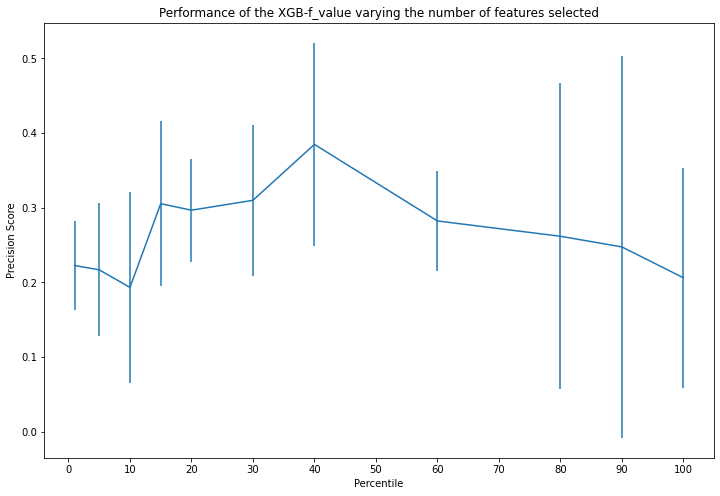

<IPython.core.display.Javascript object>

In [45]:
# #############################################################################
# Plot the cross-validation score as a function of percentile of features
score_means = list()
score_stds = list()
k_best = (10, 20, 25, 30, 35, 40, 50, 60, 70, 90, "all")

for i in tqdm(k_best):
    clf.set_params(fvalue__k=i)
    this_scores = cross_val_score(clf, X, y, cv=skf, scoring="precision")
    score_means.append(this_scores.mean())
    score_stds.append(this_scores.std())


plt.figure(figsize=(12, 8))
plt.errorbar(percentiles, score_means, np.array(score_stds))
plt.title("Performance of the XGB-f_value varying the number of features selected")
plt.xticks(np.linspace(0, 100, 11, endpoint=True))
plt.xlabel("Percentile")
plt.ylabel("Precision Score")
plt.axis("tight")
plt.show()

In [41]:
f_bestk = SelectKBest(f_classif, k=40)
f_bestk.fit_transform(X, y)

f_bestk.get_feature_names_out()
len(f_bestk.get_feature_names_out())

f_res = pd.DataFrame(
    [list(chi_perc.pvalues_), list(chi_perc.scores_)],
    index=["P_value", "Scores"],
    columns=X.columns,
).T

f_res[f_res.P_value < 0.05]

f_res[f_res.Scores > 5]

array([[0.613 , 0.4998, 0.2103, ..., 0.    , 0.    , 0.    ],
       [0.5   , 0.507 , 0.4207, ..., 0.    , 0.    , 0.    ],
       [0.661 , 0.417 , 0.4207, ..., 0.    , 0.    , 0.    ],
       ...,
       [0.5483, 0.586 , 0.3333, ..., 0.    , 0.    , 0.    ],
       [0.5967, 0.7104, 0.2103, ..., 0.    , 0.    , 0.    ],
       [0.7256, 0.5557, 0.3333, ..., 0.    , 0.    , 0.    ]],
      dtype=float16)

array(['Gest_Days', 'Weight_0m', 'Stay_Duration_Hospital',
       'Number_of_AntibioticsCourse', 'Epi_Noncold_Wheeze_3m',
       'Anesthetic_delivery', 'Home_Furry_Pets_6m', 'Mother_Asthma',
       'Father_Asthma', 'Father_Caucasian', 'Mother_Caucasian',
       'Dad_Food', 'Mom_Atopy', 'Wheeze_3m', 'RIfrequency_earlier_report',
       'RIfrequency_later_report', 'RIseverity_earlier_report',
       'RIseverity_later_report', 'PSS_36week_High_Stress',
       'PSS_36week_Low_Stress', 'CSED_36week_High_Depression',
       'CSED_36week_Low_Depression', 'PSS_18week_High_Stress',
       'PSS_18week_Low_Stress', 'PSS_6m_Low_Stress', 'PSS_6m_Missing',
       'PSS_12m_Low_Stress', 'PSS_12m_Moderate_Stress', 'Gender_M',
       'BF_Status_3m_Exclusive', 'BF_Status_3m_Partial',
       'BF_Status_6m_Partial', 'Child_Ethinicity_Caucasian',
       'Child_Ethinicity_HalfCaucas', 'Child_Ethinicity_NonCaucas',
       'Mode_of_delivery_Vaginal', 'Home_New_Furnitures_6m_Missing',
       'Analgesics_usage_d

40

,P_value,Scores
Number_of_AntibioticsCourse,0.000227,13.593395
Epi_Noncold_Wheeze_3m,0.020537,5.365660
Mother_Asthma,0.000079,15.574192
Father_Asthma,0.000014,18.906728
Wheeze_3m,0.000219,13.662723
RIseverity_later_report,0.015953,5.808098
PSS_18week_High_Stress,0.041555,4.153235
PSS_6m_Missing,0.000193,13.897915
Gender_M,0.044303,4.044969
BF_Status_3m_Partial,0.044243,4.047259


,P_value,Scores
Number_of_AntibioticsCourse,0.000227,13.593395
Epi_Noncold_Wheeze_3m,0.020537,5.365660
Mother_Asthma,0.000079,15.574192
Father_Asthma,0.000014,18.906728
Wheeze_3m,0.000219,13.662723
RIseverity_later_report,0.015953,5.808098
PSS_6m_Missing,0.000193,13.897915
Child_Ethinicity_NonCaucas,0.003526,8.513269
Home_New_Furnitures_6m_Missing,0.000198,13.847523
Home_Furry_Pets_6m_Missing,0.000198,13.847523


<IPython.core.display.Javascript object>

#### (4) False Positive Rate]   <a id='f_classif'></a>

[return](#0)

#### (2) RFE - Observation

#### (3) Chi2 - Percentile

In [ ]:
X = df_for_ml.drop(columns="y")
y = df_for_ml.y
X.shape
y.shape

In [ ]:
df_for_ml[df_for_ml.F10min_Suction == 1].y.value_counts(normalize=True)

In [ ]:
from sklearn.feature_selection import mutual_info_classif
import matplotlib.pyplot as plt

mic = mutual_info_classif(X, y)
fig, ax = plt.subplots(figsize=(10, 20))
mic_df = (
    pd.DataFrame({"feature": X.columns, "vimp": mic})
    .set_index("feature")
    .sort_values(by="vimp", ascending=True)
)
mic_df[mic_df.vimp > 0].shape[0]
mic_df[mic_df.vimp > 0].plot.barh(ax=ax)
mic_df[mic_df.vimp == 0].index.values

#### 9. Permutation Importance for non-linear estimators <a id='permutation'></a>
[return](#0)

Permutation feature importance is a model inspection technique that can be used for any fitted estimator when the data is tabular. This is especially useful for non-linear or opaque estimators. The permutation feature importance is defined to be the decrease in a model score when a single feature value is randomly shuffled. This procedure breaks the relationship between the feature and the target, thus the drop in the model score is indicative of how much the model depends on the feature. This technique benefits from being model agnostic and can be calculated many times with different permutations of the feature.

In [ ]:
def randomsubset_permutation_importance(*, clf: object, percentile_of_features: float):
    """
    As when all features are included, none of the feature will have any importance, I therefore created this function 
    to view the feature importance of a random subset of features.
    : para: percentile_of_features
    : para: clf: a classification algorithm
    : return: a visualization of feature importance for current subset of features
    """
    number_of_features = int(len(X.columns.values) * percentile_of_features)
    selected_columns = random.sample(list(X.columns.values), number_of_features)
    clf.fit(X[selected_columns], y)
    result = permutation_importance(
        clf,
        X[selected_columns],
        y,
        n_repeats=10,
        random_state=1012,
        scoring="precision",
    )
    perm_sorted_idx = result.importances_mean.argsort()
    plt.figure(figsize=(20, 10))
    plt.barh(
        width=result.importances_mean[perm_sorted_idx].T, y=X.columns[perm_sorted_idx],
    )
    r = result
    for i in r.importances_mean.argsort()[::-1]:
        if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
            print(
                f"{X.columns[i]:<8}"
                f"{r.importances_mean[i]:.3f}"
                f" +/- {r.importances_std[i]:.3f}"
            )

In [ ]:
randomsubset_permutation_importance(
    clf=RandomForestClassifier(), percentile_of_features=0.2
)

### ML Pipeline Test Run